# Sniffer Classifer Predictor
Use this notebook to run predictions with the sniffer classifier

In [57]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load the model

In [19]:
model_name="model_100_x_100"
model_path=os.getcwd()+ os.sep+"models"+os.sep+model_name

In [20]:
model = tf.keras.models.load_model(model_path+os.sep+"model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 32)       0

## Local Variables
Use these variables to change the prediction parameters for your CNN.
- `dataset_path`: directory containing the unzipped imagery
- `img_shape` : shape (width , height) your imagery will be resized to. These are inputs into the model. This must be the same size as the size you trained your model on.

In [43]:
dataset_path=os.getcwd()+os.sep+"test_images"
csv_name="mapped_test_dataset.csv"
csv_path=os.getcwd()+os.sep+csv_name
img_shape=(100, 100)

In [12]:
def pre_process_img(image,img_shape:tuple)->list:
    """returns np.array resized to (1,img_shape,3)"""
    img=image.resize(img_shape,Image.ANTIALIAS)
    imgArray = np.asarray(img)
    imgArray=imgArray.reshape((1,)+img_shape+(3,))# Create batch axis
    return imgArray

In [15]:
def one_encode_labels(df:'pandas.core.frame.DataFrame',labels=["good","bad"]):
    """ Returns the modified dataframe with the labels one hot encoded"""
    mapping = {}
    for x in range(len(labels)):
        mapping[labels[x]] = x
    # outputs {'good': 0, 'bad': 1}
    # Replace each label in sorted with corresponding one hot encoded label
    for x in range(len(df['Sorted'])):
        df['Sorted'][x] = mapping[df['Sorted'][x]]
    return df

In [53]:
def read_labeled_df(csv_path:str):
    """Returns a cleaned dataframe with the labels one hot encoded
    Use this function when you have a dataframe with correct labels
    you want to compare the model against
    """
    # Read in the labeled_df that the model has never seen before
    df=pd.read_csv(csv_path)
    if "index" in df.columns:
        print("Dropping column index")
        df.drop(['index'],axis=1,inplace=True)
    if "Unnamed: 0"in df.columns:
        print("Dropping column Unnamed: 0")
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    # one hot encode the labels in the "sorted" if they aren't already
    if df['Sorted'].dtypes !='int64':
        df=one_encode_labels(df)
    return df

In [29]:
def create_prediction_ready_data(dataset_path:str,img_shape:tuple):
    """returns a numpy array of the shape (number_images,img_shape,3)"""
    images=[]
    for image in os.listdir(dataset_path):
        img=Image.open(dataset_path+os.sep+image)
        img_array=pre_process_img(img,img_shape)
        images.append(img_array)
    data=np.vstack(images)
    return data

In [39]:
def get_predictions(data:np.array):
    """Returns a numpy array of the predicted labels"""
    predictions=model.predict(data)
    prediction_labels=[pred.flatten().argmax(axis=0) for pred in predictions]
    # Converted to float....
    # prediction_labels=np.array(prediction_labels,dtype='uint8')
    prediction_labels=np.array(prediction_labels,dtype='float')
    print(type(prediction_labels))
    return prediction_labels


In [30]:
data=create_prediction_ready_data(dataset_path,img_shape)

In [40]:
prediction_labels=get_predictions(data)
prediction_labels.shape

<class 'numpy.ndarray'>


(179,)

In [42]:
prediction_labels[:50]

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])

## Create a Confusion Matrix

In [55]:
# Read the correct labels from the dataframe
df=read_labeled_df(csv_path)
labels=df["Sorted"]

Dropping column Unnamed: 0


[[110   0]
 [ 13  56]]


Text(0.5, 24.0, 'Predicted')

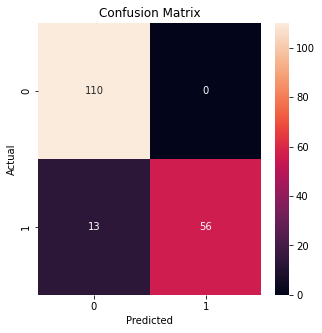

In [59]:
cm=confusion_matrix(labels,prediction_labels)
print(cm)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt='g')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

## Predict on a Single Image
---

In [60]:
image_path=r"C:\Users\Sharon\Downloads\ob-20220412T220737Z-001\ob"+os.sep+"2017-09-25-18-52-27_L8_rgbr.jpg"
img = keras.preprocessing.image.load_img(
    image_path, target_size=(100,100))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
np.array(img_array) 

<class 'numpy.ndarray'>


In [61]:
prediction=model.predict(np.array(img_array) )
reverse_mapping={0:"good",1:"bad"}
label=reverse_mapping[prediction.flatten().argmax(axis=0)]
label

'good'